The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.14.4


# Long Short Term Memory (LSTM)
:label:`sec_lstm`

The challenge to address long-term information preservation and short-term input
skipping in latent variable models has existed for a long time. One of the
earliest approaches to address this was the LSTM
:cite:`Hochreiter.Schmidhuber.1997`.  It shares many of the properties of the
Gated Recurrent Unit (GRU). Interestingly, LSTM's design is slightly more complex than GRU but predates GRU by almost two decades.

Arguably it is inspired by logic gates of a computer. To control a memory cell
we need a number of gates. One gate is needed to read out the entries from the
cell (as opposed to reading any other cell). We will refer to this as the
*output* gate. A second gate is needed to decide when to read data into the
cell. We refer to this as the *input* gate. Last, we need a mechanism to reset
the contents of the cell, governed by a *forget* gate. The motivation for such a
design is the same as before, namely to be able to decide when to remember and
when to ignore inputs in the latent state via a dedicated mechanism. Let us see
how this works in practice.

## Gated Memory Cells

Three gates are introduced in LSTMs: the input gate, the forget gate, and the output gate. In addition to that we will introduce the memory cell that has the same shape as the hidden state. Strictly speaking this is just a fancy version of a hidden state, engineered to record additional information.

### Input Gates, Forget Gates, and Output Gates

Just like with GRUs, the data feeding into the LSTM gates is the input at the current time step $\mathbf{X}_t$ and the hidden state of the previous time step $\mathbf{H}_{t-1}$. These inputs are processed by a fully connected layer and a sigmoid activation function to compute the values of input, forget and output gates. As a result, the three gates' all output values are in the range of $[0, 1]$. :numref:`lstm_0` illustrates the data flow for the input, forget, and output gates.

![Calculation of input, forget, and output gates in an LSTM. ](http://d2l.ai/_images/lstm_0.svg)
:label:`lstm_0`

We assume that there are $h$ hidden units, the minibatch is of size $n$, and number of inputs is $d$. Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ and the hidden state of the last time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Correspondingly, the gates are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. They are calculated as follows:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

where $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ are bias parameters.


### Candidate Memory Cell

Next we design the memory cell. Since we have not specified the action of the various gates yet, we first introduce the *candidate* memory cell $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$. Its computation is similar to the three gates described above, but using a $\tanh$ function with a value range for $[-1, 1]$ as the activation function. This leads to the following equation at time step $t$.

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c).$$

Here $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ is a bias parameter.

A quick illustration of the candidate memory cell is shown in :numref:`lstm_1`.

![Computation of candidate memory cells in LSTM. ](http://d2l.ai/_images/lstm_1.svg)
:label:`lstm_1`


### Memory Cell

In GRUs, we had a single mechanism to govern input and forgetting. Here in LSTMs we have two parameters, $\mathbf{I}_t$ which governs how much we take new data into account via $\tilde{\mathbf{C}}_t$ and the forget parameter $\mathbf{F}_t$ which addresses how much of the old memory cell content $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. Using the same pointwise multiplication trick as before, we arrive at the following update equation.

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

If the forget gate is always approximately $1$ and the input gate is always approximately $0$, the past memory cells $\mathbf{C}_{t-1}$ will be saved over time and passed to the current time step. This design was introduced to alleviate the vanishing gradient problem and to better capture dependencies for time series with long range dependencies. We thus arrive at the flow diagram in :numref:`lstm_2`.

![Computation of memory cells in an LSTM. Here, the multiplication is carried out elementwise. ](http://d2l.ai/_images/lstm_2.svg)

:label:`lstm_2`


### Hidden States

Last, we need to define how to compute the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$. This is where the output gate comes into play. In LSTM it is simply a gated version of the $\tanh$ of the memory cell. This ensures that the values of $\mathbf{H}_t$ are always in the interval $(-1, 1)$. Whenever the output gate is $1$ we effectively pass all memory information through to the predictor, whereas for output $0$ we retain all the information only within the memory cell and perform no further processing. :numref:`lstm_3` has a graphical illustration of the data flow.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

![Computation of the hidden state. Multiplication is elementwise. ](http://d2l.ai/_images/lstm_3.svg)
:label:`lstm_3`



## Implementation from Scratch

Now let us implement an LSTM from scratch. As same as the experiments in the previous sections, we first load data of *The Time Machine*.


In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Initializing Model Parameters

Next we need to define and initialize the model parameters. As previously, the hyperparameter `num_hiddens` defines the number of hidden units. We initialize weights following a Gaussian distribution with $0.01$ standard deviation, and we set the biases to $0$.


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=device)

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                np.zeros(num_hiddens, ctx=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

### Defining the Model

In the initialization function, the hidden state of the LSTM needs to return an additional memory cell with a value of $0$ and a shape of (batch size, number of hidden units). Hence we get the following state initialization.


In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (np.zeros((batch_size, num_hiddens), ctx=device),
            np.zeros((batch_size, num_hiddens), ctx=device))

The actual model is defined just like what we discussed before: providing three gates and an auxiliary memory cell. Note that only the hidden state is passed to the output layer. The memory cells $\mathbf{C}_t$ do not participate in the output computation directly.


In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = npx.sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i)
        F = npx.sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f)
        O = npx.sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o)
        C_tilda = np.tanh(np.dot(X, W_xc) + np.dot(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * np.tanh(C)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H, C)

### Training and Prediction

Let us train an LSTM as same as what we did in :numref:`sec_gru`, by calling the `RNNModelScratch` function as introduced in :numref:`sec_rnn_scratch`.


perplexity 1.1, 10949.7 tokens/sec on gpu(0)
time traveller but now you begin to seethe object of my investig


travelleryou can show black is white by argument said filby


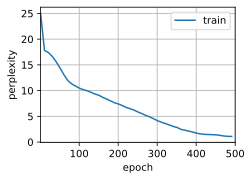

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Concise Implementation

In Gluon, we can directly call the `LSTM` class in the `rnn` module. This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out in detail before.


perplexity 1.1, 170160.5 tokens/sec on gpu(0)
time traveller for so it will be convenient to speak of himwas e


travelleryou can show black is white by argument said filby


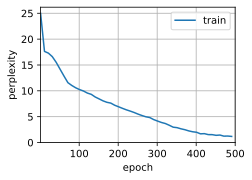

In [6]:
lstm_layer = rnn.LSTM(num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In many cases, LSTMs perform slightly better than GRUs but they are more costly to train and execute due to the larger latent state size. LSTMs are the prototypical latent variable autoregressive model with nontrivial state control. Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. However, training LSTMs and other sequence models (such as GRU) are quite costly due to the long range dependency of the sequence. Later we will encounter alternative models such as Transformers that can be used in some cases.


## Summary

* LSTMs have three types of gates: input gates, forget gates, and output gates which control the flow of information.
* The hidden layer output of LSTM includes hidden states and memory cells. Only hidden states are passed into the output layer. Memory cells are entirely internal.
* LSTMs can cope with vanishing and exploding gradients.


## Exercises

1. Adjust the hyperparameters. Observe and analyze the impact on runtime, perplexity, and the generated output.
1. How would you need to change the model to generate proper words as opposed to sequences of characters?
1. Compare the computational cost for GRUs, LSTMs, and regular RNNs for a given hidden dimension. Pay special attention to the training and inference cost.
1. Since the candidate memory cells ensure that the value range is between $-1$ and $1$ by  using the $\tanh$ function, why does the hidden state need to use the $\tanh$ function again to ensure that the output value range is between $-1$ and $1$?
1. Implement an LSTM for time series prediction rather than character sequence prediction.


[Discussions](https://discuss.d2l.ai/t/343)
